In [1]:
import numpy as np
import pandas as pd

#!pip install pyEDFlib
import pyedflib
#!pip install ipympl

from scipy.fftpack import fft, ifft, fftfreq
from scipy import signal as sg
from scipy.ndimage.filters import gaussian_filter1d, gaussian_filter
from scipy.stats import binned_statistic, entropy, norm
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import sys
import os
import time
#import pickle
import dill as pickle

import concurrent.futures
from numba import jit, njit, prange

from tqdm.notebook import tqdm
from collections import defaultdict
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
#from IPython.display import display
sns.set(context='notebook', style='ticks', palette='bright', font='sans-serif', font_scale=1, color_codes=True, rc=None)
plt.rcParams['figure.figsize'] = (10, 6)

#print("SYS.PATH: ", sys.path[:3])
#sys.path.insert(0, r"C:\Users\User\[[Python]]\[AlexeyT]\PAC_PROJECT")

from utility_functions import *
#from class_lfp import LFP
#from class_pac import MyPAC
#from class_patient import Patient
%run utility_functions.py
%run lfp_class.py
%run pac_class.py
%run patient_class.py

print("Succesfully imported libraries and modules\n")

Succesfully imported libraries and modules



We want to correlate spectral power and PAC intensity for a given frequency range.

Spectral power can be calculated 2 ways:
1) Sliding window over frequency and averaging spectral power (I suggest window size equal to 1.5 * bandwidth of PAC estimation filter for phase-giving oscillation)
2) FOOOF 1/f removal and estimation of power of whitened spectrum and/or sliding window spectral power mean

PAC intensity could be calculated as following:
* We don't consider y-axis frequencies below 150 Hz (N:M coupling occurs mostly below that point)
* Average or max-value (or any matrix norm essentially) of **significant** PAC in every column corresponding to the phase-giving frequency



In [2]:
def copy_patient(patient: Patient):
    new_patient = Patient(patient.name, patient.root_dir)
    for attr in patient.__dict__.keys():
        new_patient.__dict__[attr] = patient.__dict__[attr]
    return new_patient

In [3]:
def load_patients(who='all', n_total=6):
    """
    who: either all or list of patient numbers
    Returns: list of patient instances
    """
    
    with open("path_data.txt") as f:
        data_dir = f.readline()
        print(f"Reading patients in directory {data_dir}")
        
    p_list = []
        
    if who == 'all':
        iterable = range(1, n_total + 1)    
    else:
        iterable = who
        
    for i in iterable:
        print(f"Reading Patient{i}")
        p_dir = os.path.join(data_dir, f"Patient{i}")
        p_pickle_filepath = os.path.join(p_dir, f"Patient{i}.pkl")
        p = load_patient_from_pickle(p_pickle_filepath)
        p = copy_patient(p)
        p.root_dir = p_dir
        p.load_all_pacs(verbose=False)
        p_list.append(p)
        
    print("Done, returning list of patients")
    return p_list

## Patient 1: Beta - PAC correlation

In [4]:
p1 = load_patient(1)

Patient directory:  D:\LAB\AlexPAC\data\Patient1


In [17]:
# example PAC and lfp spectrum

condition = "5Day OFF Rest 180sec"
placement = "R2B-3B"

pac = p1.pac[condition][placement][placement]
lfp = p1.lfp[condition][placement]

print(pac.beta_params)

(5, 48, 1, 2)


(array([   0.,    1.,    2., ...,  998.,  999., 1000.]),
 array([5.75768618e-04, 2.51329400e-04, 7.68960405e-04, ...,
        1.25647875e-07, 4.87842131e-08, 3.16807463e-09]))

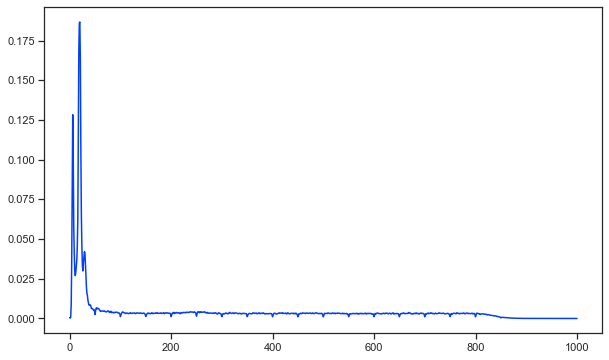

In [19]:
plt.plot(*lfp.get_psd())

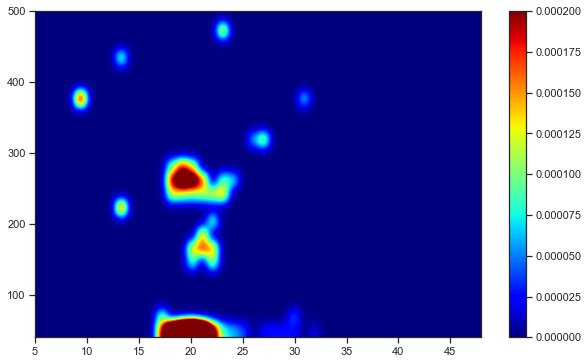

In [22]:
comodulogram(pac.pac_matrix, pac.beta_params, pac.hfo_params, pac.pvalues, significant=True, vmax=0.0002)
plt.colorbar()

#### LFP spectral power

In [33]:
f1, f2 = 4, 36 # beta freqs of interest (we really want from 5 to 35 but that's another story )

f, psd = lfp.get_psd()
mask = (f >= f1) & (f <= f2)

kernel = np.ones(3)/3
psd_average_power = np.convolve(psd[mask], kernel, mode='valid')
# Получили скользящее среднее, при этом первая точка отвечает за 5, а последняя - за 35 - отлично! 31 точка всего

33
31
31


#### PAC power

In [63]:
zero_indices = (pac.pvalues > 0.01)
pac_matrix = pac.pac_matrix.copy()
pac_matrix[zero_indices] = 0

# average pac power above 160Hz is [6:, :].mean(axis=0)
# for beta it is 5 to 35

pac_power_mean = pac_matrix[6:, :31].mean(axis=0)
pac_power_max = pac_matrix[6:, :31].max(axis=0)
pac_power_mean.shape

(31,)

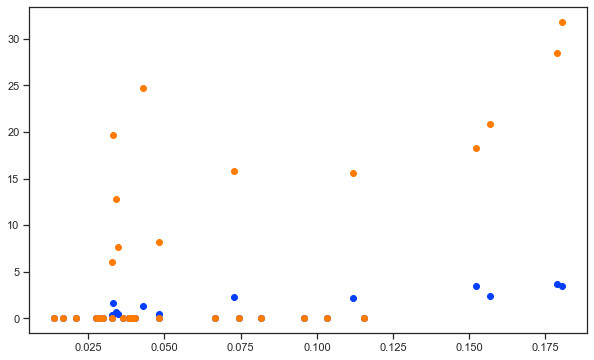

In [64]:
plt.scatter(psd_average_power, pac_power_mean * 1e+5)
plt.scatter(psd_average_power, pac_power_max * 1e+5)

In [66]:
np.corrcoef(psd_average_power, pac_power_max)

array([[1.        , 0.62428048],
       [0.62428048, 1.        ]])

In [68]:
spectral_power = np.array([])
pac_max_power = np.array([])
pac_mean_power = np.array([])

for condition in p1.conditions:
    if '180sec' in condition:
        for placement in p1.placements:
            lfp = p1.lfp[condition][placement]
            pac = p1.pac[condition][placement][placement]
            
            # spectral power
            f1, f2 = 4, 36
            f, psd = lfp.get_psd()
            mask = (f >= f1) & (f <= f2)

            kernel = np.ones(3)/3
            psd_average_power = np.convolve(psd[mask], kernel, mode='valid')
            
            # pac power
            zero_indices = (pac.pvalues > 0.01)
            pac_matrix = pac.pac_matrix.copy()
            pac_matrix[zero_indices] = 0

            pac_mean = pac_matrix[6:, :31].mean(axis=0)
            pac_max = pac_matrix[6:, :31].max(axis=0)
            
            spectral_power = np.concatenate((spectral_power, psd_average_power))
            pac_max_power = np.concatenate((pac_max_power, pac_max))
            pac_mean_power = np.concatenate((pac_mean_power, pac_mean))

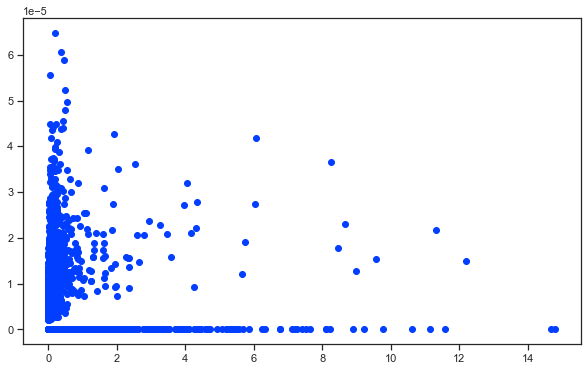

In [72]:
plt.scatter(spectral_power, pac_mean_power)

In [76]:
print(np.corrcoef(spectral_power, pac_mean_power))

print(np.corrcoef(spectral_power, pac_max_power))

[[1.         0.09880446]
 [0.09880446 1.        ]]
[[1.         0.12266818]
 [0.12266818 1.        ]]


Fixing Patient3 with copying its attributes

In [8]:
with open("path_data.txt") as f:
    data_dir = f.readline()
p3_dir = os.path.join(data_dir, "Patient3")
print("Patient directory: ", p3_dir)
p3_pickle_filepath = os.path.join(p3_dir, "Patient3.pkl")
p3 = load_patient_from_pickle(p3_pickle_filepath)
p3.root_dir = p3_dir

p3 = copy_patient(p3)

p3.load_all_pacs(verbose=False)
p3.save()

Patient directory:  D:\LAB\AlexPAC\data\Patient3
